# Stacking Ensemble Machine Learning (Stacked Generalization)
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score
import pickle

import plotly.express as px

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("../Datas/data.csv")

In [3]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

In [4]:
df_final_X = df.drop(["datetime","count"], axis=1)
df_final_y = np.log1p(df["count"])


In [5]:
df_final_X.describe()

,season,holiday,workingday,weather,temp,humidity,windspeed,month,day_number,year,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418335,20.23086,61.886460,12.799395,6.521495,9.992559,2011.501929,11.541613
std,1.116174,0.166599,0.466159,0.633537,7.79159,19.245033,8.164537,3.444373,5.476608,0.500019,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.000000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,47.000000,7.001500,4.000000,5.000000,2011.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,62.000000,12.998000,7.000000,10.000000,2012.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,77.000000,16.997900,10.000000,15.000000,2012.000000,18.000000
max,4.000000,1.000000,1.000000,3.000000,41.00000,100.000000,56.996900,12.000000,19.000000,2012.000000,23.000000


In [6]:
df_final_y.describe()

count    10886.000000
mean         4.591364
std          1.419454
min          0.693147
25%          3.761200
50%          4.983607
75%          5.652489
max          6.885510
Name: count, dtype: float64

In [7]:
one_hot_features = ["weather", "holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [8]:

# get a list of models to evaluate



In [9]:
rfr = make_pipeline(processor, RandomForestRegressor(random_state=1))
etr = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
lgbm = make_pipeline(processor, LGBMRegressor(random_state=1))
xgbr = make_pipeline(processor, XGBRegressor(random_state=1))

In [10]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
    models = dict()
    models['rfr'] = make_pipeline(processor, RandomForestRegressor(random_state=1))
    models['etr'] = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
    models['lgbm'] = make_pipeline(processor, LGBMRegressor(random_state=1))
    models['xgbr'] = make_pipeline(processor, XGBRegressor(random_state=1))
    
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train, X_test, y_test):
	
	model.fit(X_train, y_train)
	scores = model.score(X_test, y_test)

	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model,X_train, y_train, X_test, y_test)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>rfr 0.905 (0.000)
>etr 0.938 (0.000)
>lgbm 0.930 (0.000)
>xgbr 0.925 (0.000)


In [11]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingRegressor

# define the base models
level0 = list()

level0.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1)
# fit the model on all available data
model.fit(X_train, y_train)
# make a prediction for one example

y_pred = model.predict(X_test)
# print('Predicted Value: %.3f' % (y_pred))

In [12]:
model.score(X_test,y_test)

0.9351436450058414

In [13]:
model.stack_method

'predict'

In [14]:
tmp = {'y_test': y_test, 'y_pred':y_pred}
result = pd.DataFrame(data=tmp , columns=['y_test','y_pred'])
result['diff'] = result['y_test'] - result['y_pred'] 

In [15]:
X_test

,season,holiday,workingday,weather,temp,humidity,windspeed,day,month,day_number,year,hour
9063,3,0,0,1,30.34,62,7.0015,Saturday,9,1,2012,0
9064,3,0,0,1,29.52,74,8.9981,Saturday,9,1,2012,1
9065,3,0,0,1,28.70,70,11.0014,Saturday,9,1,2012,2
9066,3,0,0,1,28.70,70,7.0015,Saturday,9,1,2012,3
9067,3,0,0,1,28.70,70,0.0000,Saturday,9,1,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,Wednesday,12,19,2012,19
10882,4,0,1,1,14.76,57,15.0013,Wednesday,12,19,2012,20
10883,4,0,1,1,13.94,61,15.0013,Wednesday,12,19,2012,21
10884,4,0,1,1,13.94,61,6.0032,Wednesday,12,19,2012,22


In [16]:


X_test_res = X_test
X_test_res["diff"] = result['y_test'] - result['y_pred'] 

px.scatter(X_test_res,y='diff',hover_data=["hour","humidity","temp","windspeed"])
#fig.update_traces(mode="markers")
# fig.show()

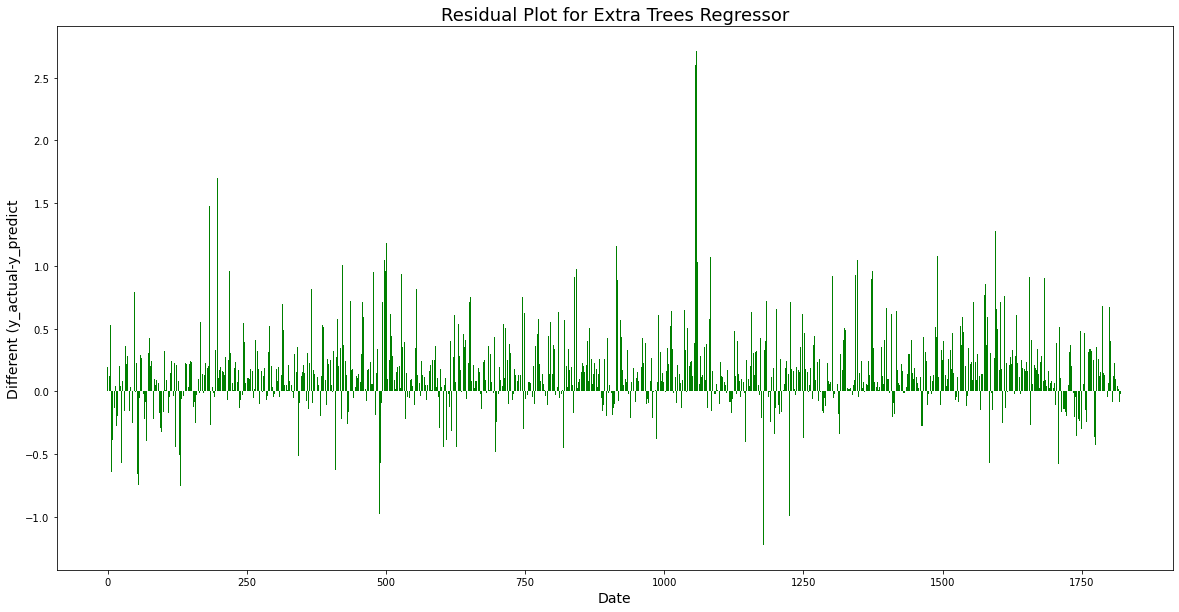

In [17]:
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
plt.title('Residual Plot for Extra Trees Regressor',fontsize=18)
x_axis = list(range(0, len(result)))
ax.bar(x_axis, result['diff'],color='green')
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Different (y_actual-y_predict',fontsize=14)

# ax2=ax.twinx()
# ax2.plot(df_group_month_sum['date_data'], df_group_month_sum['atemp'],color='blue',marker="o")
# ax2.set_ylabel('Feels like temperature')
plt.show()

## Plot y_pred vs y_actual for all

In [18]:
etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)

rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

model.fit(X_train, y_train)
y_pred_stack = model.predict(X_test)


In [19]:
y_test

9063     5.129899
9064     4.382027
9065     4.248495
9066     3.583519
9067     2.564949
           ...   
10881    5.820083
10882    5.488938
10883    5.129899
10884    4.867534
10885    4.488636
Name: count, Length: 1823, dtype: float64

In [20]:
plot_y_etr = pd.DataFrame(data=y_test, columns=['y_test'])
# plot_y_etr['y_test'] = y_test
plot_y_etr['y_test']=y_test
plot_y_etr['y_pred_etr']=y_pred_etr
plot_y_etr['y_pred_rfr']=y_pred_rfr
plot_y_etr['y_pred_xgbr']=y_pred_xgbr
plot_y_etr['y_pred_lgbm']=y_pred_lgbm
plot_y_etr['y_pred_stack']=y_pred_stack
plot_y_etr

,y_test,y_pred_etr,y_pred_rfr,y_pred_xgbr,y_pred_lgbm,y_pred_stack
9063,5.129899,5.078499,5.037487,4.931859,4.944779,4.937878
9064,4.382027,4.558402,4.613553,4.780262,4.721122,4.730161
9065,4.248495,4.209002,4.271408,4.478359,4.278377,4.268696
9066,3.583519,3.518858,3.533116,3.667225,3.492948,3.458277
9067,2.564949,2.239840,2.233777,2.659561,2.468180,2.459904
...,...,...,...,...,...,...
10881,5.820083,6.032792,5.710064,5.842140,5.781391,5.907364
10882,5.488938,5.612399,5.326273,5.653399,5.439787,5.571515
10883,5.129899,5.375965,5.034620,5.195533,5.041114,5.146614
10884,4.867534,5.124311,4.749576,4.977775,4.760090,4.872641


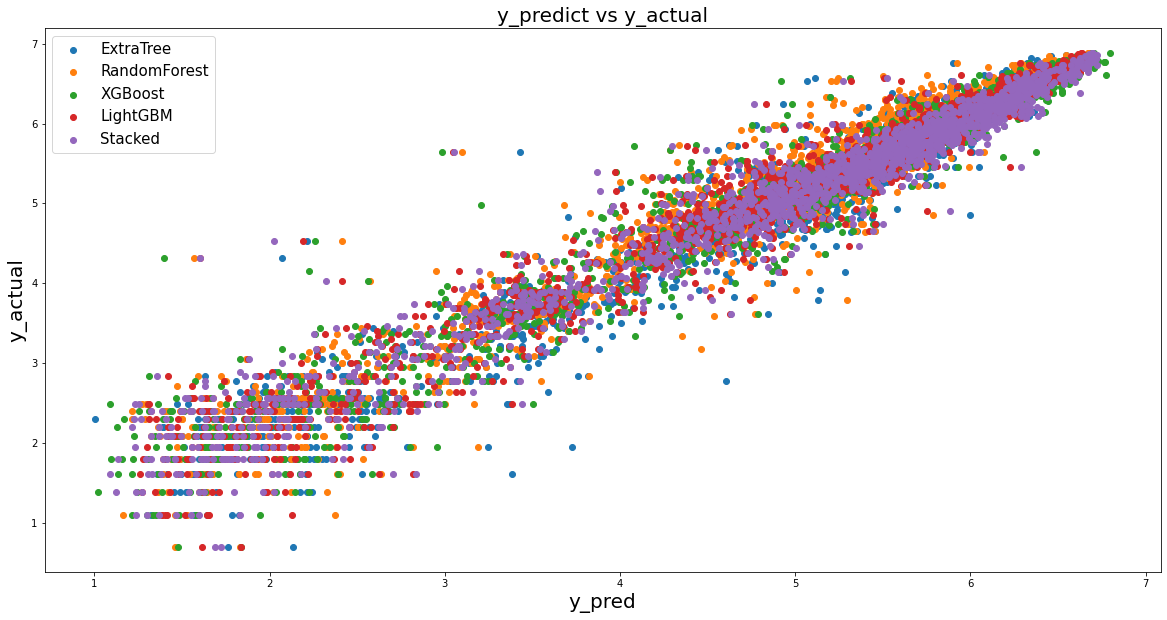

In [21]:
plt.scatter(plot_y_etr['y_pred_etr'], plot_y_etr['y_test'],label='ExtraTree')
plt.scatter(plot_y_etr['y_pred_rfr'], plot_y_etr['y_test'],label='RandomForest')
plt.scatter(plot_y_etr['y_pred_xgbr'], plot_y_etr['y_test'],label='XGBoost')
plt.scatter(plot_y_etr['y_pred_lgbm'], plot_y_etr['y_test'],label='LightGBM')
plt.scatter(plot_y_etr['y_pred_stack'], plot_y_etr['y_test'],label='Stacked')
plt.title('y_predict vs y_actual', fontsize=20)
plt.xlabel('y_pred', fontsize=20)
plt.ylabel('y_actual', fontsize=20)
plt.legend(fontsize=15)

# Package using pickle library

In [22]:
model.fit(df_final_X, df_final_y)


StackingRegressor(estimators=[('rfr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['weather',
                                                                                  'holiday',
                                                                                  'workingday',
                                                                                  'season',
                                                                                  'month',
                                                                             

- pickle.dump(model_xgb, open(filename, 'wb'))
- loaded_model = pickle.load(open(filename, 'rb'))

In [23]:
model

StackingRegressor(estimators=[('rfr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['weather',
                                                                                  'holiday',
                                                                                  'workingday',
                                                                                  'season',
                                                                                  'month',
                                                                             

In [24]:
# pickle.dump(model, open('model_stack.sav', 'wb'))

In [25]:
loaded_model = pickle.load(open('model_stack.sav', 'rb'))

In [26]:
loaded_model.score(X_test,y_test)

0.9788335974542952

## Smaller pickle files

In [27]:
# etr.fit(X_train, y_train)
# pickle.dump(model, open('model_etr.sav', 'wb'))

# rfr.fit(X_train, y_train)
# pickle.dump(model, open('model_rfr.sav', 'wb'))

# xgbr.fit(X_train, y_train)
# pickle.dump(model, open('model_xgbr.sav', 'wb'))

# lgbm.fit(X_train, y_train)
# pickle.dump(model, open('model_lgbm.sav', 'wb'))

# model.fit(X_train, y_train)


In [28]:
level0 = list()

loaded_model1 = pickle.load(open('model_etr.sav', 'rb'))
loaded_model2 = pickle.load(open('model_rfr.sav', 'rb'))
loaded_model3 = pickle.load(open('model_xgbr.sav', 'rb'))
loaded_model4 = pickle.load(open('model_lgbm.sav', 'rb'))

level0.append(('rfr', loaded_model1))
level0.append(('etr', loaded_model2))
level0.append(('lgbm', loaded_model3))
level0.append(('xgbr', loaded_model4))

# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1)
# fit the model on all available data
model.fit(X_train, y_train)
score = model.score(X_test,y_test)
score

ValueError: Names provided are not unique: ['rfr', 'etr', 'lgbm', 'xgbr', 'rfr', 'etr', 'lgbm', 'xgbr']

In [29]:
level0.append(('rfr', make_pipeline(processor, RandomForestRegressor(random_state=1))))
level0.append(('etr', make_pipeline(processor, ExtraTreesRegressor(random_state=1))))
level0.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))



# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1)
# fit the model on all available data
model.fit(X_train, y_train)
# make a prediction for one example

y_pred = model.predict(X_test)

ValueError: Invalid 'estimators' attribute, 'estimators' should be a list of (string, estimator) tuples.